In [138]:
from fastcore.test import test_eq
from fastcore.basics import first
from fastai.data.external import untar_data, URLs
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import Categorify, FillMissing
from fastai.data.transforms import Normalize
import pandas as pd

In [139]:
from tsai.all import *

In [140]:
gMLPClassification

tsai.models.gMLP.gMLPClassification

In [141]:
GatedTabTransformer

tsai.models.GatedTabTransformer.GatedTabTransformer

# gMLPClassification `tsai` learner demo
Demo showing the gMLPClassification extension of the original gMLP ***(Liu H., et al., 2021)*** proposed in ***(Cholakov R. & Kolev T., 2022)***.

In [151]:
X, y, splits = get_classification_data('ECG200', split_data=False)
batch_tfms = TSStandardize()

epoch,train_loss,valid_loss,accuracy,time
0,0.662866,0.667074,0.640000,00:01
1,0.665502,0.657550,0.640000,00:00
2,0.645590,0.661507,0.640000,00:00
3,0.638351,0.691685,0.640000,00:00
4,0.623110,0.720279,0.640000,00:00
5,0.633343,0.651905,0.640000,00:00
6,0.621614,0.583205,0.640000,00:00
7,0.610414,0.570783,0.750000,00:00
8,0.603201,0.535490,0.750000,00:00
9,0.592740,0.510904,0.760000,00:00


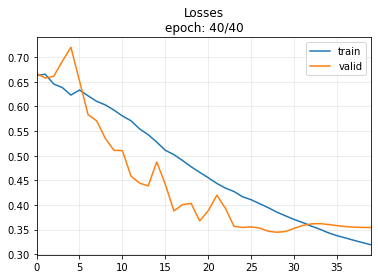

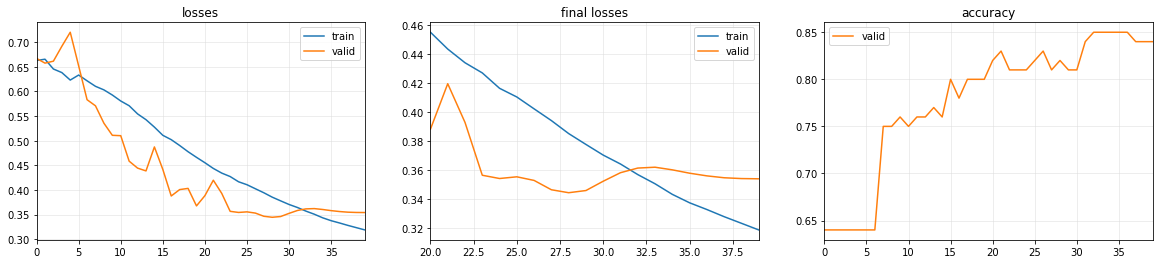

In [143]:
clf = TSClassifier(X, y, splits=splits, arch=gMLPClassification, arch_config={"patch_size": 4}, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
clf.fit_one_cycle(40, 3e-4)

# GatedTabTransformer `PyTorch` demo
Demo showing the proposed GatedTabTransformer ***(Cholakov R. & Kolev T., 2022)*** as a part of a standard PyTorch training process (imported using `tsai`).

In [144]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,36,Private,297449,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Male,14084,0,40,United-States,>=50k
32557,23,?,123983,Bachelors,13.0,Never-married,?,Own-child,Other,Male,0,0,40,United-States,<50k
32558,53,Private,157069,Assoc-acdm,12.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>=50k
32559,32,Local-gov,217296,HS-grad,9.0,Married-civ-spouse,Transport-moving,Wife,White,Female,4064,0,22,United-States,<50k


In [145]:
dls = TabularDataLoaders.from_df(df, path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [146]:
model = GatedTabTransformer(dls.classes, dls.cont_names, dls.c)

In [147]:
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [148]:
for epoch in range(1):
    running_loss = 0.0

    for i, batch in enumerate(dls.train):

        x_cat, x_cont, yb = batch
        
        optimizer.zero_grad()
        out = model(x_cat, x_cont)
        loss = criterion(out, yb.squeeze().to(dtype=torch.long))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 19:
            print('[%d, %6d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    
    scheduler.step()

[1,     20] loss: 0.580734
[1,     40] loss: 0.543058
[1,     60] loss: 0.500973
[1,     80] loss: 0.475136
[1,    100] loss: 0.396163
[1,    120] loss: 0.377020
[1,    140] loss: 0.375302
[1,    160] loss: 0.405428
[1,    180] loss: 0.371216
[1,    200] loss: 0.379084
[1,    220] loss: 0.363322
[1,    240] loss: 0.378617
[1,    260] loss: 0.388669
[1,    280] loss: 0.394753
[1,    300] loss: 0.353997
[1,    320] loss: 0.369271
[1,    340] loss: 0.343762
[1,    360] loss: 0.373091
[1,    380] loss: 0.368624
[1,    400] loss: 0.377348


# GatedTabTransformer `tsai` learner demo

epoch,train_loss,valid_loss,accuracy,time
0,0.371679,0.355549,0.834459,02:39


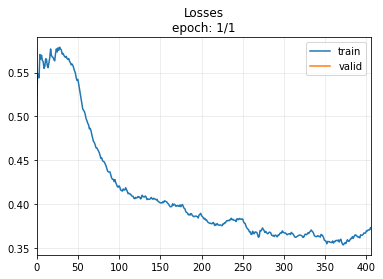

not enough values to plot a chart


In [150]:
model = GatedTabTransformer(dls.classes, dls.cont_names, dls.c)
learn = Learner(dls, model, cbs=ShowGraph(), metrics=accuracy)
learn.fit_one_cycle(1)